In [1]:
import pandas as pd
import numpy as np
import tqdm
import torch

# Pre processing

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.nn import EdgeConv, global_mean_pool

class EdgeNetPool(nn.Module):
    def __init__(self, input_dim=4, big_dim=32, hidden_dim=2, n_particles=100, aggr='mean'):
        self.input_dim = input_dim
        self.big_dim = big_dim
        self.hidden_dim = hidden_dim
        self.n_particles = n_particles
        self.aggr = aggr
        super(EdgeNet, self).__init__()
        encoder_nn = nn.Sequential(nn.Linear(2*(self.input_dim), self.big_dim),
                               nn.ReLU(),
                               nn.Linear(self.big_dim, self.big_dim),
                               nn.ReLU(),
        )
        
        decoder_nn = nn.Sequential(nn.Linear(self.n_particles*self.big_dim, self.n_particles*self.big_dim),
                               nn.ReLU(),
                               nn.Linear(self.n_particles*self.big_dim, self.n_particles*self.input_dim)
        )
        
        self.batchnorm = nn.BatchNorm1d(input_dim)

        self.encoder = EdgeConv(nn=encoder_nn,aggr=aggr)
        self.decoder = EdgeConv(nn=decoder_nn,aggr=aggr)

    def forward(self, data):
        data.x = self.batchnorm(data.x)
        data.x = self.encoder(data.x,data.edge_index)
        data.u = global_mean_pool(data.x)
        data.x = torch.reshape(self.decoder(data.u), (self.n_particles, self.input_dim))
        return data.x

In [16]:
import torch
from torch_geometric.data import Data, DataLoader
import os
import os.path as osp
import math
import argparse
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from graph_data import GraphDataset

gdata = GraphDataset(root='/anomalyvol/data/graph100particles',n_particles=100)

input_dim = 4
big_dim = 32
hidden_dim = 2
fulllen = len(gdata)
tv_frac = 0.10
tv_num = math.ceil(fulllen*tv_frac)
splits = np.cumsum([fulllen-2*tv_num,tv_num,tv_num])
batch_size = 512
n_epochs = 1
lr = 0.001
patience = 10
device = 'cuda:0'
model_fname = 'EdgeNetPool'

model = EdgeNet(input_dim=input_dim, big_dim=big_dim, hidden_dim=hidden_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

In [8]:
train_dataset = GraphDataset(root='/anomalyvol/data/graph100particles',n_particles=100,start=0,stop=splits[0])
valid_dataset = GraphDataset(root='/anomalyvol/data/graph100particles',n_particles=100,start=splits[1],stop=splits[2])
test_dataset = GraphDataset(root='/anomalyvol/data/graph100particles',n_particles=100,start=splits[0 ],stop=splits[1])

train_loader = DataLoader(train_dataset, batch_size=batch_size, pin_memory=True, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, pin_memory=True, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, pin_memory=True, shuffle=False)

train_samples = len(train_dataset)
valid_samples = len(valid_dataset)
test_samples = len(test_dataset)

print(train_samples)
print(valid_samples)
print(test_samples)
print(train_dataset[0])

24043
2405
2405
Data(edge_index=[2, 420], x=[100, 4], y=[100, 4])


In [9]:
@torch.no_grad()
def test(model,loader,total,batch_size):
    model.eval()
    
    mse = nn.MSELoss(reduction='mean')

    sum_loss = 0.
    t = tqdm.tqdm(enumerate(loader),total=total/batch_size)
    for i,data in t:
        data = data.to(device)
        batch_output = model(data)
        batch_loss_item = mse(batch_output, data.y).item()
        sum_loss += batch_loss_item
        t.set_description("loss = %.5f" % (batch_loss_item))
        t.refresh() # to show immediately the update

    return sum_loss/(i+1)

def train(model, optimizer, loader, total, batch_size):
    model.train()
    
    mse = nn.MSELoss(reduction='mean')

    sum_loss = 0.
    t = tqdm.tqdm(enumerate(loader),total=total/batch_size)
    for i,data in t:
        data = data.to(device)
        optimizer.zero_grad()
        batch_output = model(data)
        batch_loss = mse(batch_output, data.y)
        batch_loss.backward()
        batch_loss_item = batch_loss.item()
        t.set_description("loss = %.5f" % batch_loss_item)
        t.refresh() # to show immediately the update
        sum_loss += batch_loss_item
        optimizer.step()
    
    return sum_loss/(i+1)

In [10]:
n_epochs = 20

In [ ]:
stale_epochs = 0
best_valid_loss = 99999
for epoch in range(0, n_epochs):
    loss = train(model, optimizer, train_loader, train_samples, batch_size)
    valid_loss = test(model, valid_loader, valid_samples, batch_size)
    print('Epoch: {:02d}, Training Loss:   {:.4f}'.format(epoch, loss))
    print('               Validation Loss: {:.4f}'.format(valid_loss))

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        modpath = osp.join('/anomalyvol/models/gnn/',model_fname+'.best.pth')
        print('New best model saved to:',modpath)
        torch.save(model.state_dict(),modpath)
        stale_epochs = 0
    else:
        print('Stale epoch')
        stale_epochs += 1
    if stale_epochs >= patience:
        print('Early stopping after %i stale epochs'%patience)
        break

  0%|          | 0/46.958984375 [00:00<?, ?it/s]

In [8]:
model.load_state_dict(torch.load(modpath))
input_x = []
output_x = []

t = tqdm.tqdm(enumerate(test_loader),total=test_samples/batch_size)
for i, data in t:
    data.to(device)
    input_x.append(data.x.cpu().numpy())
    output_x.append(model(data).cpu().detach().numpy())

106%|██████████| 5/4.697265625 [00:11<00:00,  2.32s/it]


(134117,)
(134117,)


(array([0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 1.0000e+00, 3.0000e+00, 2.0000e+00,
        1.0000e+00, 1.0000e+00, 2.0000e+00, 4.0000e+00, 4.0000e+00,
        6.0000e+00, 6.0000e+00, 4.0000e+00, 1.0000e+01, 1.0000e+01,
        1.4000e+01, 1.6000e+01, 1.3000e+01, 2.2000e+01, 3.5000e+01,
        2.9000e+01, 5.6000e+01, 5.9000e+01, 9.4000e+01, 1.4400e+02,
        1.8900e+02, 3.9100e+02, 7.4300e+02, 1.7850e+03, 3.8930e+03,
        6.3450e+03, 8.7110e+03, 1.0683e+04, 1.3712e+04, 1.6029e+04,
        1.4285e+04, 1.1533e+04, 9.1660e+03, 7.3700e+03, 5.5000e+03,
        4.1620e+03, 3.1280e+03, 2.4760e+03, 1.8040e+03, 1.5170e+03,
        1.2370e+03, 1.0060e+03, 8.6800e+02, 7.5700e+02, 5.8600e+02,
        5.3700e+02, 4.6000e+02, 3.7800e+02, 3.3400e+02, 2.8700e+02,
        2.6200e+02, 2.3100e+02, 2.3400e+02, 1.96

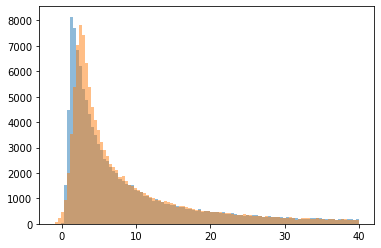

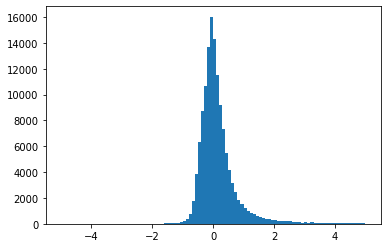

In [37]:
diff = []
output_px = []
input_px = []
for i in range(len(input_x)):
    diff.append(((output_x[i][:,3]-input_x[i][:,3])/input_x[i][:,3]).flatten())
    output_px.append(output_x[i][:,3].flatten())
    input_px.append(input_x[i][:,3].flatten())
    
all_diff = np.concatenate(diff)
all_input_px = np.concatenate(input_px)
all_output_px = np.concatenate(output_px)

print(all_input_px.shape)
print(all_output_px.shape)

plt.figure()
plt.hist(all_input_px, bins=np.linspace(-1, 40, 101),alpha=0.5)
plt.hist(all_output_px, bins=np.linspace(-1, 40, 101),alpha=0.5)

plt.figure()
plt.hist(all_diff, bins=np.linspace(-5, 5, 101))

In [26]:
max(all_input_px)

3245.6025